In [222]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

from torch import nn
from tqdm.auto import tqdm
from torchinfo import summary
from torchvision import models
from tqdm.notebook import tqdm
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [223]:
data_transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])

train_set = datasets.VOCSegmentation(root="./data",
                                      year="2012",
                                      image_set="train",
                                      transform=data_transform,
                                      target_transform=data_transform)

val_set = datasets.VOCSegmentation(root="./data",
                                     year="2012",
                                     image_set="trainval",
                                   
                                     transform=data_transform,
                                     target_transform=data_transform)

test_set = datasets.VOCSegmentation(root="./data", year="2012", image_set="val")

In [224]:
train_loader = DataLoader(train_set, batch_size=3, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=3, shuffle=True, drop_last=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=3, shuffle=True, drop_last=True)

In [225]:
class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet50(pretrained=True)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        auxiliary_x = self.resnet.layer1(x)
        x = self.resnet.layer2(auxiliary_x)

        return x, auxiliary_x

In [226]:
class PyramidPoolingModule(nn.Module):

    def __init__(self, pools, in_channels, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.pooling_layers = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=p), # Pool
                nn.Conv2d(in_channels, int(in_channels / len(pools)), 1, 1, 0, 1, bias=False),
                nn.Dropout2d()
            )
            for p in pools
        ])

    def forward(self, x):
        outputs = [x]
        for pooling_layer in self.pooling_layers:
            layer_output = pooling_layer(x)
            outputs.append(F.interpolate(layer_output, size=self.input_shape, mode="bilinear", align_corners=True))

        return torch.cat(outputs, dim=1)

In [227]:
class SegmentationClassifier(nn.Module):

    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.segmentation = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Dropout2d(),
            nn.UpsamplingBilinear2d(scale_factor=scale_factor)
        )

    def forward(self, x):
        return self.segmentation(x)

In [228]:
class PSPNet(nn.Module):
    def __init__(self, input_shape, n_classes):
        super().__init__()
        self.feature_extractor = CustomResNet()
        self.pyramid_pooling = PyramidPoolingModule(input_shape=(int(input_shape[0] / 8), int(input_shape[1] / 8)), in_channels=512, pools = (6, 3, 2, 1))
        self.classifier = SegmentationClassifier(in_channels=1024, out_channels=n_classes, scale_factor=8)
        self.aux_classifier = SegmentationClassifier(in_channels=256, out_channels=n_classes, scale_factor=4)

    def forward(self, x):
        encoder_outputs, encoder_auxiliary = self.feature_extractor(x)
        pyramid_outputs = self.pyramid_pooling(encoder_outputs)
        return self.classifier(pyramid_outputs), self.aux_classifier(encoder_auxiliary)

In [229]:
model = PSPNet(input_shape=(256,256), n_classes=20)
summary(model, input_size=(3, 3, 256, 256))

Layer (type:depth-idx)                             Output Shape              Param #
PSPNet                                             [3, 20, 256, 256]         --
├─CustomResNet: 1-1                                [3, 512, 32, 32]          --
│    └─ResNet: 2-1                                 --                        24,112,104
│    │    └─Conv2d: 3-1                            [3, 64, 128, 128]         9,408
│    │    └─BatchNorm2d: 3-2                       [3, 64, 128, 128]         128
│    │    └─ReLU: 3-3                              [3, 64, 128, 128]         --
│    │    └─MaxPool2d: 3-4                         [3, 64, 64, 64]           --
│    │    └─Sequential: 3-5                        [3, 256, 64, 64]          215,808
│    │    └─Sequential: 3-6                        [3, 512, 32, 32]          1,219,584
├─PyramidPoolingModule: 1-2                        [3, 1024, 32, 32]         --
│    └─ModuleList: 2-2                             --                        --
│    │    └

In [230]:
class_frequencies = [0.64, 0.059, 0.052, 0.031, 0.02, 0.019, 0.018, 0.016, 0.015, 0.013, 0.012, 0.011, 0.01, 0.01, 0.009, 0.009, 0.007, 0.007, 0.007, 0.003]

total_samples = sum(class_frequencies)
class_weights = [total_samples / freq for freq in class_frequencies]
class_weights = [weight / sum(class_weights) for weight in class_weights]
class_weights = torch.tensor(class_weights).to(device)

In [231]:
class DeepSupervisionLoss(nn.Module):
    def __init__(self, alpha):
        super().__init__()
        self.alpha = alpha
        self.cross_entropy = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, output, target):
        loss = self.cross_entropy(output[0], target)
        aux_loss = self.cross_entropy(output[1], target)
        return loss + self.alpha * aux_loss

In [278]:
criterion = smp.losses.DiceLoss(mode="multiclass")
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

In [240]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    model.to(device)
    train_loss = []
    val_loss = []
    for e in tqdm(range(epochs)):
        model.train()
        epoch_train_loss = []
        for i, (img, mask) in enumerate(train_loader):
            img = img.to(device)
            mask = mask
            mask = mask.to(device)
            output, _ = model(img)
            loss = criterion(output, mask.squeeze().long())
            epoch_train_loss.append(loss.cpu().detach().numpy())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        epoch_val_loss = []
        with torch.inference_mode():
            for i, (img, mask) in enumerate(val_loader):
                img = img.to(device)
                mask = mask
                mask = mask.to(device)
                output, _ = model(img)
                loss = criterion(output, mask.squeeze().long())
                epoch_val_loss.append(loss.cpu().detach().numpy())

        train_loss.append(np.mean(epoch_train_loss))
        val_loss.append(np.mean(epoch_val_loss))

        print(f"Epoch {e} | Loss: {np.mean(epoch_train_loss)} | Val Loss: {np.mean(epoch_val_loss)}")

    return train_loss, val_loss

In [423]:
train_loss, val_loss = fit(50, model, train_loader, val_loader, criterion, optimizer)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 | Loss: 0.04601488262414932 | Val Loss: 0.02681262418627739
Epoch 1 | Loss: 0.04593290016055107 | Val Loss: 0.026875650510191917
Epoch 2 | Loss: 0.04683521389961243 | Val Loss: 0.0268248338252306
Epoch 3 | Loss: 0.04629473388195038 | Val Loss: 0.02705303020775318
Epoch 4 | Loss: 0.045536067336797714 | Val Loss: 0.027126334607601166
Epoch 5 | Loss: 0.04516119882464409 | Val Loss: 0.02745780535042286
Epoch 6 | Loss: 0.046198852360248566 | Val Loss: 0.026866596192121506
Epoch 7 | Loss: 0.046841878443956375 | Val Loss: 0.02680468000471592
Epoch 8 | Loss: 0.04805604740977287 | Val Loss: 0.02724781632423401
Epoch 9 | Loss: 0.0447595939040184 | Val Loss: 0.027105005457997322
Epoch 10 | Loss: 0.04774517938494682 | Val Loss: 0.027049843221902847
Epoch 11 | Loss: 0.04722223058342934 | Val Loss: 0.026907652616500854
Epoch 12 | Loss: 0.046529415994882584 | Val Loss: 0.026911815628409386
Epoch 13 | Loss: 0.04716596379876137 | Val Loss: 0.0270621869713068
Epoch 14 | Loss: 0.04677137732505798

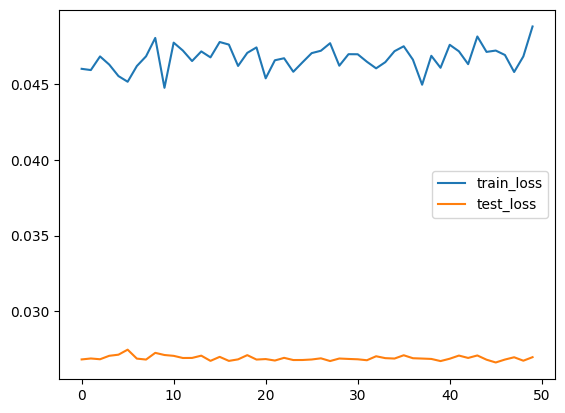

In [424]:
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="test_loss")
plt.legend()

In [437]:
torch.save(model.state_dict(), "./models/01_pspnet_pascalvoc_5.pth")

In [244]:
def predict_image_mask(model, image):
    model.eval()
    model.to(device)
    image = image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)
        output, _ = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.00

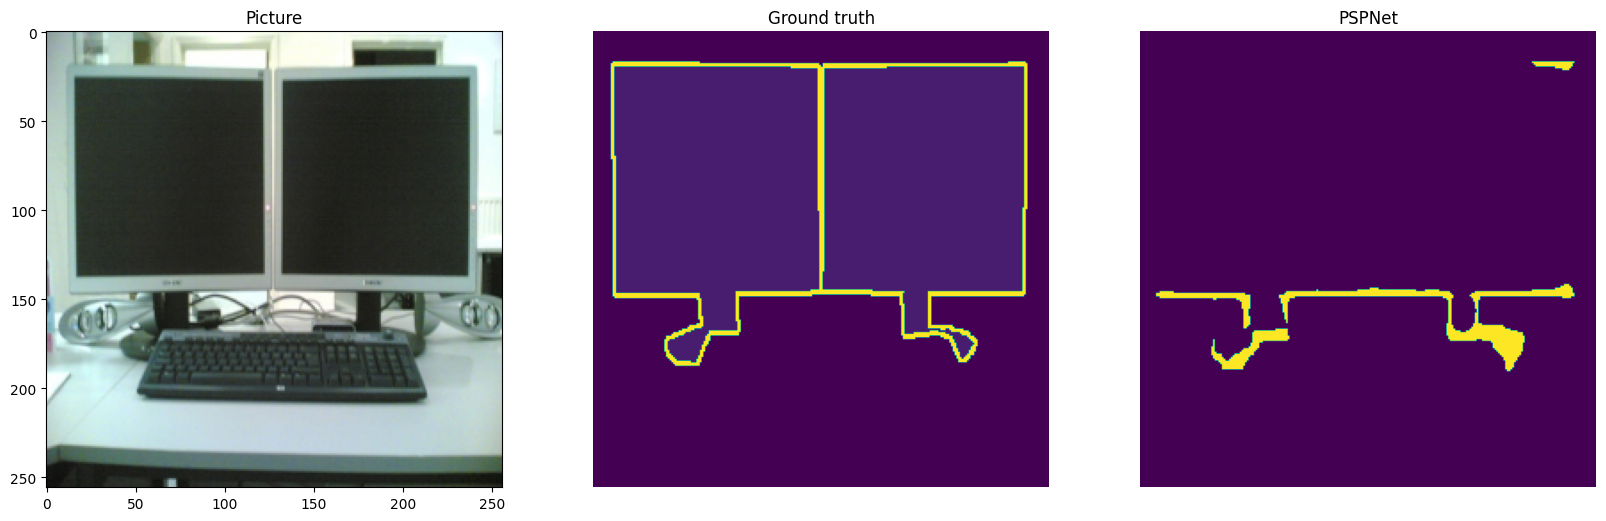

In [436]:
image, mask = val_set[7]
torch.set_printoptions(linewidth=200)
torch.set_printoptions(profile="full")
print(mask)
pred_mask = predict_image_mask(model, image)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(T.ToPILImage()(image))
ax1.set_title('Picture')

ax2.imshow(mask.squeeze())
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('PSPNet')
ax3.set_axis_off()